# ДЗ_12: Нейронные сети. Автокодировщики

In [71]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [72]:
# hyperparams
#inp_dim = 28 * 28
#try to use other model params. check overfitting with large models
#hidden = 350
#out_dim = 20
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 3
batch_size = 128

In [73]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [87]:
dataset_test[123]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000,  0.6941,  0.9922, -0.7961, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

## Обучить AE собственной архитектуры на MNIST

In [95]:
input_channels = 1
hidden_channels = 100

In [96]:
class ConvEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=1) # 28x28
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.pl1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.pl2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv3 = nn.Conv2d(hidden_ch, 1, kernel_size=3, padding=1, stride=1) # 7x7


    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pl1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.pl2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.conv3(x)

    #print("src", x.shape)
    #x = self.conv1(x)
    #print("conv1", x.shape)
    #x = self.bn1(x)
    #x = self.activ(x)
    #x = self.do1(x)
    #x = self.pl1(x)
    #print("pl1", x.shape)
    #x = self.conv2(x)
    #print("conv2", x.shape)
    #x = self.bn2(x)
    #x = self.activ(x)
    #x = self.do2(x)
    #x = self.pl2(x)
    #print("pl2", x.shape)
    #x = self.conv3(x)
    #print("conv3", x.shape)
    

    return x

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, padding=1, stride=1) # 7x7
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, padding=2, stride=1) # 28x28
    
    self.activ = nn.ReLU()
  
  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.upsample2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.conv3(x)

    return x

class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [97]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() #TODO try to use MAE


epoch: 0, step: 0, loss: 0.9715335369110107
epoch: 0, step: 200, loss: 0.07172100245952606
epoch: 0, step: 400, loss: 0.06250512599945068


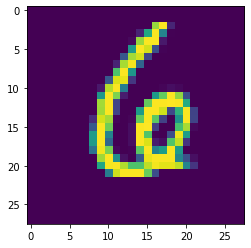

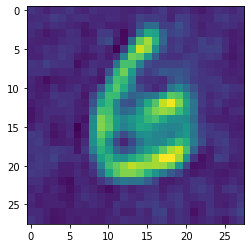

epoch: 1, step: 0, loss: 0.05567147582769394
epoch: 1, step: 200, loss: 0.05495378002524376
epoch: 1, step: 400, loss: 0.04890769347548485


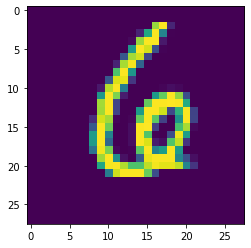

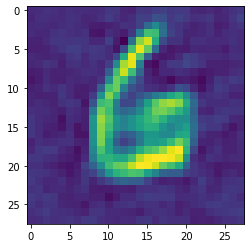

epoch: 2, step: 0, loss: 0.048139892518520355
epoch: 2, step: 200, loss: 0.042653754353523254
epoch: 2, step: 400, loss: 0.04153980314731598


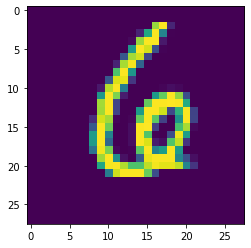

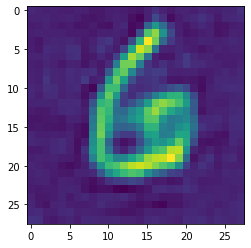

In [98]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        #print(predict)
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[123][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[123][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./conv_ae_chkpt_{epoch}.pth')

Попробуем MAE loss

In [99]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE

epoch: 0, step: 0, loss: 1.095811367034912
epoch: 0, step: 200, loss: 0.15385349094867706
epoch: 0, step: 400, loss: 0.12730158865451813


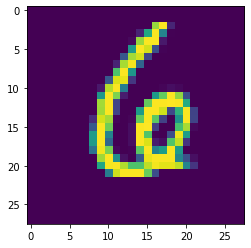

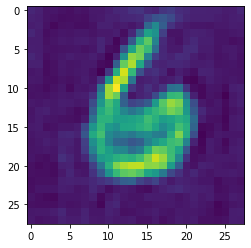

epoch: 1, step: 0, loss: 0.15971317887306213
epoch: 1, step: 200, loss: 0.12687073647975922
epoch: 1, step: 400, loss: 0.12287190556526184


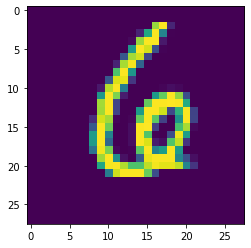

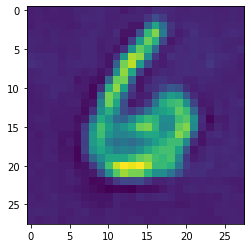

epoch: 2, step: 0, loss: 0.11148030310869217
epoch: 2, step: 200, loss: 0.1035480871796608
epoch: 2, step: 400, loss: 0.10090011358261108


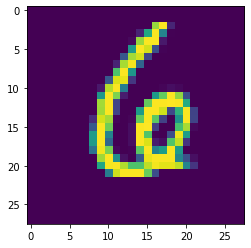

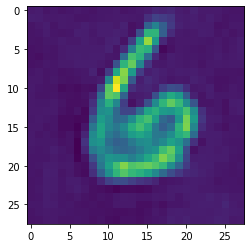

In [100]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        #print(predict)
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[123][0].unsqueeze(0).to(device).float()
    plt.imshow(dataset_test[123][0].squeeze().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./conv_ae_chkpt_mae_{epoch}.pth')

Таким образом, при прочих равных MSE loss работает лучше MAE loss (после 3х эпох в 2 раза)

epoch: 0, step: 0, loss: 1.3002381324768066
epoch: 0, step: 200, loss: 0.12471426278352737
epoch: 0, step: 400, loss: 0.1090361550450325


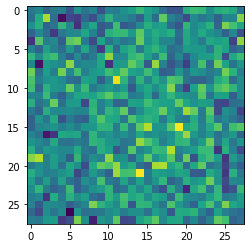

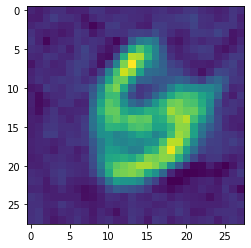

epoch: 1, step: 0, loss: 0.1136934906244278
epoch: 1, step: 200, loss: 0.10836338251829147
epoch: 1, step: 400, loss: 0.10485668480396271


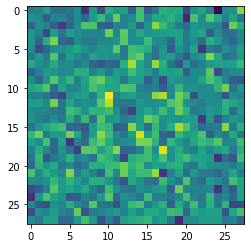

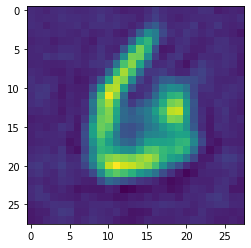

epoch: 2, step: 0, loss: 0.10397447645664215
epoch: 2, step: 200, loss: 0.1050872951745987
epoch: 2, step: 400, loss: 0.103485107421875


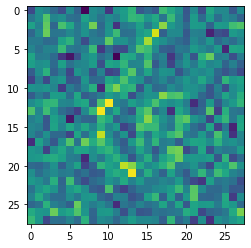

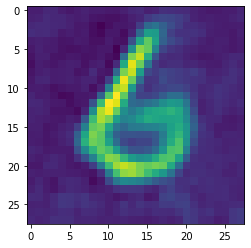

In [101]:
# денойзинг
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() 

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        noise_inputs = inputs + \
        torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 1.5
        predict = model(noise_inputs)
        loss = loss_func(inputs, predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[123][0].unsqueeze(0).to(device).float()
    item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 1.5
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

## Обучить VAE собственной архитектуры на MNIST

In [102]:
class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=1) # 28x28
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.pl1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.pl2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv3_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    self.conv3_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, padding=1) # 7x7
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pl1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.pl2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    mu = self.conv3_mu(x)
    sigma = torch.exp(self.conv3_sigma(x))

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, dropout_p=0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, padding=1, stride=1) # 7x7
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.do1 = nn.Dropout(dropout_p)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.do2 = nn.Dropout(dropout_p)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, padding=2, stride=1) # 28x28
    
    self.activ = nn.ReLU()
  
  def forward(self, x):
    x = self.upsample1(self.do1(self.activ(self.bn1(self.conv1(x)))))
    x = self.upsample2(self.do2(self.activ(self.bn2(self.conv2(x)))))
    x = self.conv3(x)

    return x

def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)


    return x_, mu, sigma

epoch: 0, step: 0, loss: 1.4314510822296143
epoch: 0, step: 200, loss: 0.09207217395305634
epoch: 0, step: 400, loss: 0.07985379546880722


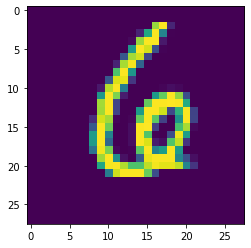

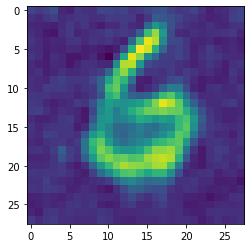

epoch: 1, step: 0, loss: 0.07963983714580536
epoch: 1, step: 200, loss: 0.07472686469554901
epoch: 1, step: 400, loss: 0.07147140800952911


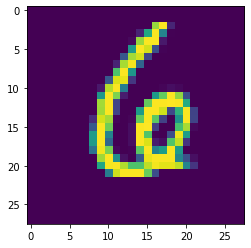

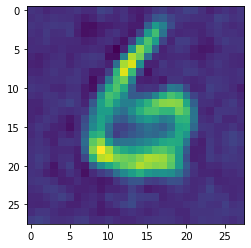

epoch: 2, step: 0, loss: 0.06969894468784332
epoch: 2, step: 200, loss: 0.07094870507717133
epoch: 2, step: 400, loss: 0.06721515953540802


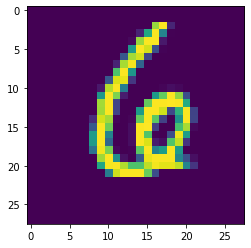

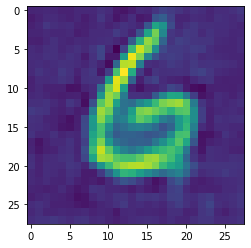

In [106]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss() #TODO try to use MAE

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        # noise_inputs = inputs + \
        # torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict, mu, sigma = model(inputs)
        loss = loss_func(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[123][0].unsqueeze(0).to(device).float()
    # item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7
    plt.imshow(item.squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    plt.imshow(model(item)[0].squeeze().squeeze().cpu().detach().numpy())
    plt.show()
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

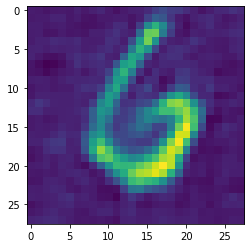

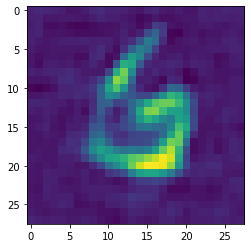

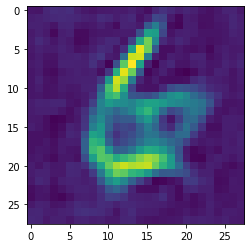

In [112]:
item = dataset_test[123][0].unsqueeze(0).to(device).float()
mu, sigma = model.encoder(item)

for _ in range(3):
    hid = torch.normal(torch.zeros((1,1,7,7)), torch.ones((1,1,7,7))).to(device) * 0.4 + mu

    plt.imshow(model.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    plt.show()